--> Importing/Loading required libraries

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import os
from tqdm import tqdm
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from keras.losses.Loss import BinaryFocalLoss
# import focal_loss
%matplotlib inline

In [ ]:
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    # plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    # plt.plot(history.history['val_accuracy'], color='orange', label='test')
    # plt.close()

# Dataset

In [ ]:
#@title Mount Drive { display-mode: "form" }
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To access the dataset directly from my drive:
<ol>
<li>Go to <b>Shared with me</b> in Google Drive.
<li>Select the folder or file you want to acess.
<li>Right click on it and choose <b>Add shortcut to drive.</b>
<li>A pop-up window will apear, Select <b>MyDrive</b> then click on <b>Add Shortcut.</b>
<li>Now, Go to your Google Colab Notebook and mount to Google Drive with:

```from google.colab import drive drive.mount("/content/gdrive")```

<li>Let's suppose you want to access a folder called 'Dataset', you can do this with:

```dataset_dir = '/content/gdrive/My Drive/Dataset'```

STARE dataset for unet:  https://drive.google.com/drive/folders/1bFT3TycxUetOtN5FeOW6XHijR-alIOdy?usp=sharing<br>
> **Desc :** 20 images - labeled by 2 people



In [ ]:
img_path = '/content/gdrive/MyDrive/Unet STARE Dataset/stare-images'
label_path = '/content/gdrive/MyDrive/Unet STARE Dataset/labels-vk'

In [ ]:
img_data = np.array([list(cv2.resize(cv2.imread(os.path.join(img_path,i)), (512,512), interpolation=cv2.INTER_CUBIC)) for i in os.listdir(img_path)])
label_data = np.array([list(cv2.resize(cv2.imread(os.path.join(label_path,i), 0), (512,512), interpolation=cv2.INTER_CUBIC)) for i in os.listdir(label_path)])/255

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img_data, label_data, test_size=0.2, random_state=42)

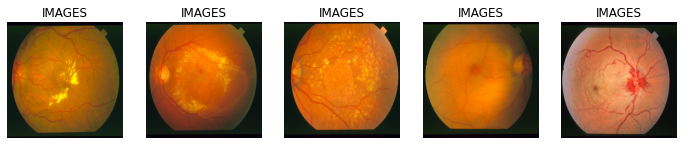

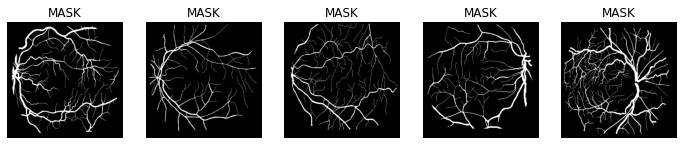

In [ ]:
#Datase
# fig,ax=plt.subplots(4,5)
# for i in img_data:
fig=plt.figure(figsize=(12,12))
for i in range(5):
  fig.add_subplot(1,5,i+1)  
  plt.imshow(cv2.cvtColor((img_data[i]),cv2.COLOR_BGR2RGB))
  plt.title('IMAGES')
  plt.axis("off")
plt.show()  

fig=plt.figure(figsize=(12,12))
for i in range(5):
  fig.add_subplot(1,5,i+1)  
  plt.imshow(label_data[i],cmap='gray')
  plt.title('MASK')
  plt.axis("off")  

# Models

Attention gated unet<br>
<font size = 2><b>Note : </b>model.compile commented<br>to facilitiate custom compilation</font>



In [ ]:
'''
Unet implementation - DEPTH => 4;
+ Attention Gates
'''
def createUnet(summary = True, IMG_SHAPE=(128,128,3)):

    inputs=keras.layers.Input(IMG_SHAPE)
    s=keras.layers.Lambda(lambda x: x/255)(inputs) # Normalising image

    # Blk-1 DEPTH=>0
    c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
    c1=keras.layers.Dropout(0.1)(c1)
    c1=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=keras.layers.MaxPooling2D((2,2))(c1)

    # Blk-2 DEPTH=>1
    c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=keras.layers.Dropout(0.1)(c2)
    c2=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=keras.layers.MaxPooling2D((2,2))(c2)

    # Blk-3 DEPTH=>2
    c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=keras.layers.Dropout(0.2)(c3)
    c3=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=keras.layers.MaxPooling2D((2,2))(c3)

    # Blk-4 DEPTH=>3
    c4=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=keras.layers.Dropout(0.2)(c4)
    c4=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=keras.layers.MaxPooling2D(pool_size=(2,2))(c4)

    # Blk-5 DEPTH=>4
    c5=keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=keras.layers.Dropout(0.3)(c5)
    c5=keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)

    #expansive path

    # Blk-6 Depth=>3
    l6=keras.layers.Conv2D(128,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(c5)                 
    u6=keras.layers.Conv2D(128,(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding='same')(c4)  
    # attention gate 4
    a6=keras.layers.add([l6,u6])
    a6=keras.layers.ReLU()(a6)
    a6=keras.layers.Conv2D(1,(1,1),kernel_initializer='he_normal',padding='same')(a6)
    a6=keras.layers.Activation('sigmoid')(a6)
    # u6=keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(a6)
    u6=keras.layers.UpSampling2D((2,2))(a6)
    u6=keras.layers.Lambda(lambda x, repnum: keras.backend.repeat_elements(x, repnum, axis=3),arguments={'repnum': 128})(u6)
    u6=keras.layers.multiply([u6,c4])
    c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=keras.layers.Dropout(0.2)(c6)
    c6=keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    # Blk-7 Depth=>2
    l7=keras.layers.Conv2D(64,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(c6)
    u7=keras.layers.Conv2D(64,(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    # attention gate 3
    a7=keras.layers.add([l7,u7])
    a7=keras.layers.ReLU()(a7)
    a7=keras.layers.Conv2D(1,(1,1),kernel_initializer='he_normal',padding='same')(a7)
    a7=keras.layers.Activation('sigmoid')(a7)
    # u7=keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(a7)
    u7=keras.layers.UpSampling2D((2,2))(a7)
    u7=keras.layers.Lambda(lambda x, repnum: keras.backend.repeat_elements(x, repnum, axis=3),arguments={'repnum': 64})(u7)
    u7=keras.layers.multiply([u7,c3])
    c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=keras.layers.Dropout(0.2)(c7)
    c7=keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    # Blk-8 DEPTH=>1
    l8=keras.layers.Conv2D(32,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(c7)
    u8=keras.layers.Conv2D(32,(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    # atteniton gate 2
    a8=keras.layers.add([l8,u8])
    a8=keras.layers.ReLU()(a8)
    a8=keras.layers.Conv2D(1,(1,1),kernel_initializer='he_normal',padding='same')(a8)
    a8=keras.layers.Activation('sigmoid')(a8)
    # u8=keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(a8)
    u8=keras.layers.UpSampling2D((2,2))(a8)
    u8=keras.layers.Lambda(lambda x, repnum: keras.backend.repeat_elements(x, repnum, axis=3),arguments={'repnum': 32})(u8)
    u8=keras.layers.multiply([u8,c2])
    c8=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=keras.layers.Dropout(0.1)(c8)
    c8=keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    # BLk-9 Depth=>0 (Output Layer)
    l9=keras.layers.Conv2D(16,(1,1),activation='relu',kernel_initializer='he_normal',padding='same')(c8)
    u9=keras.layers.Conv2D(16,(2,2),strides=(2,2),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    # attention gate 1
    a9=keras.layers.add([l9,u9])
    a9=keras.layers.ReLU()(a9)
    a9=keras.layers.Conv2D(1,(1,1),kernel_initializer='he_normal',padding='same')(a9)
    a9=keras.layers.Activation('sigmoid')(a9)
    # u9=keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(a9)
    u9=keras.layers.UpSampling2D((2,2))(a9)
    u9=keras.layers.Lambda(lambda x, repnum: keras.backend.repeat_elements(x, repnum, axis=3),arguments={'repnum': 16})(u9)
    u9=keras.layers.multiply([u9,c1])
    c9=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=keras.layers.Dropout(0.1)(c9)
    c9=keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    outputs=keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

    model=keras.Model(inputs=[inputs],outputs=[outputs])
    # model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',keras.metrics.BinaryIoU([0,1])])
    model.compile(optimizer='adam',loss=[tf.keras.losses.BinaryFocalCrossentropy(gamma=2)],metrics=['accuracy',keras.metrics.BinaryIoU([0])])
    if summary:
        model.summary()
    return model
# createUnet(0, x_train[0])

#Images & mask preprocessing

<font size = "5">adjustData(img,mask,flag_multi_class,num_class)</font><br>
This func maps class data given in the first value for each pixel to a bool list of size num_calss for each pixel. Also normalises the image and masks.
<br><u>Eg</u><br> `pixel = [[2,5]]` --> class = 2 <br> then <br> `mask = [[0.,0.,1.,0.]]` index '2' is 1 rest are 0.
<br><br> Pre-Built in keras for the same use `keras.utils.to_categorical()`

In [ ]:
def adjustData(img,mask,flag_multi_class,num_class):
    
    img = img/255 if(np.max(img) > 1) else img
    mask = mask/255 if(np.max(mask) > 1) else mask
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    if(flag_multi_class):
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    return (img,mask)

#Img Loader

<font size = "5">**Note :**
ImageDataGenerator used in the github code that we are executing is shown as <u>*depricated*</u> in the Tensorflow documentation.
</font>
<p> They have adviced to use


# Training model

In [ ]:
model = createUnet(0, x_train[0].shape)

In [ ]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='loss'),
        tf.keras.callbacks.TerminateOnNaN()]
history = model.fit(x_train, y_train, epochs=100, batch_size=16, callbacks = callbacks)

Epoch 1/100
1/1 [==============================] - 42s 42s/step - loss: 0.1766 - accuracy: 0.4912 - binary_io_u: 0.5032
Epoch 2/100
1/1 [==============================] - 36s 36s/step - loss: 0.1669 - accuracy: 0.7199 - binary_io_u: 0.7761
Epoch 3/100
1/1 [==============================] - 36s 36s/step - loss: 0.1617 - accuracy: 0.8067 - binary_io_u: 0.8776
Epoch 4/100
1/1 [==============================] - 36s 36s/step - loss: 0.1502 - accuracy: 0.8337 - binary_io_u: 0.9090
Epoch 5/100
1/1 [==============================] - 36s 36s/step - loss: 0.1352 - accuracy: 0.8456 - binary_io_u: 0.9228
Epoch 6/100
1/1 [==============================] - 36s 36s/step - loss: 0.1234 - accuracy: 0.8475 - binary_io_u: 0.9250
Epoch 7/100
1/1 [==============================] - 36s 36s/step - loss: 0.1152 - accuracy: 0.8478 - binary_io_u: 0.9253
Epoch 8/100
1/1 [==============================] - 36s 36s/step - loss: 0.1132 - accuracy: 0.8478 - binary_io_u: 0.9254
Epoch 9/100
1/1 [=======================

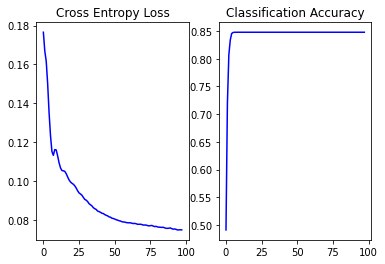

In [ ]:
summarize_diagnostics(history)

# Testing

In [ ]:
model.evaluate(x_test, y_test)

1/1 [==============================] - 3s 3s/step - loss: 0.0818 - accuracy: 0.8509 - binary_io_u: 0.9256


[0.08182203024625778, 0.8508701324462891, 0.9255733489990234]

In [ ]:
model.evaluate(x_test[0:1], y_test[0:1])

1/1 [==============================] - 1s 562ms/step - loss: 0.0688 - accuracy: 0.8728 - binary_io_u: 0.9358


[0.0687551498413086, 0.8728103637695312, 0.9358367919921875]

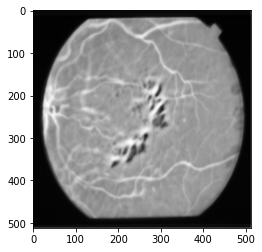

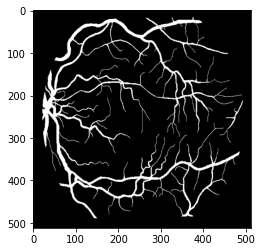

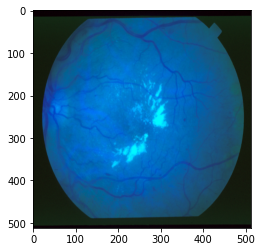

In [ ]:
plt.imshow(np.reshape(model.predict(x_test[0:1]), (512,512)), cmap="gray")
plt.show()
plt.imshow(y_test[0], cmap="gray")
plt.show()
plt.imshow(x_test[0])
plt.show()

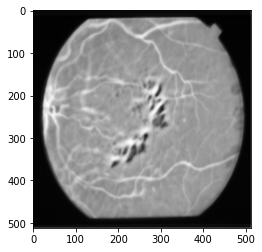

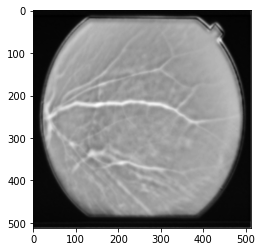

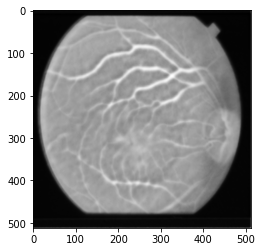

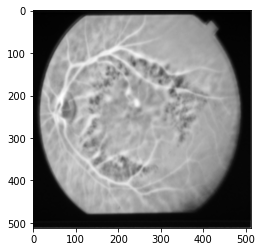

In [ ]:
for img in model.predict(x_test):
  plt.imshow(img[:,:,0], cmap='gray')
  plt.show()